In [1]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('./'))
from mds.mds import distance, b_matrix
from mds.rotation3sphere import cartesian_to_hyperspherical
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


**IDEA:**
<br>$(S^3,S^2,\pi,S^1)$ is a fiber bundle, where $\pi : S^3 \to S^2$ being the Hopf
fibration, and for every $p\in S^2, \pi^{-1}(p)=S^1$. What this essentially
means is that $S^3$ is all the possible combinations of the fiber corresponding
to each point in $S^2$. Therefore, if we are able to measure distances in $S^2$
in terms of how similar the induced fibers are, we can draw the points in $S^2$
accordingly and have a first idea of the structure of $S^3$.

- Sampling points from $S^2$ uniformly: We can use the Fibonacci sampling 
- For each of these points, we need to sample points from their corresponding fiber
(the same amount for each point) 
- Between every two points of $S^2$ that we sampled, compute the distance between 
the corresponding fibers (registration distance). For this, we need to solve: 
<br>A*=$\underset{A}{\min}\langle C, A \rangle$, such that $A\mathbf{1}_{n}=\mathbf{1}_{n}, \ A^{\top}\mathbf{1}_{n}=\mathbf{1}_{n}$
where $C\in\mathbb{R}^{n\times n}$ contains the pairwise distances between points 
on the fibers.
<br>The optimal $A$ is a permutation which registers both sets of fiber points.
The registration distance is then $d_{fibers} = \langle C,A^*\rangle$.

- Figure out a meaningful combination distance for the final merging + visualization.
<br>$d_{total}(p,q)=\sqrt{d_{geod}^2(p,q)+\alpha d_{fibers}^2(p,q)}$
<br> We need to figure out how much more/less important is the similarity of the fibers compared to the geodesic distance between points in the base manifold.
Also, the different orders of magnitude in $d_{geod}$ and $d_{fibers}$ should be accounted for.

- Visualization: mds into $\mathbb{R}^3$ with distance matrix constructed using the distance $d_{total}$

In [2]:
def localcoordsampling_2sphere(n):
    """
    Generate approximately equidistant points on the 2-sphere and return them in
    spherical coordinates (local parametrization).

    Parameters:
    n (int): Number of points to sample.

    Returns:
    np.ndarray: Array of shape (n, 2), where each row is (theta, phi).
    """
    phi = (1 + np.sqrt(5)) / 2

    points = np.zeros((n, 2))

    for k in range(n):
        theta = np.arccos(1 - 2 * (k + 0.5) / n)  # Latitude (theta), range [0, π]
        phi_k = 2 * np.pi * (k / phi**2)          # Longitude (phi), range [0, 2π]

        points[k, 0] = theta
        points[k, 1] = phi_k

    return points

In [3]:
def hopf_fibration_inverse(points, num_samples, hyperspherical=False):
    """
    Computes the inverse Hopf fibration for multiple points on S^2.
    
    Parameters:
        points (ndarray): Array of shape (N, 2) containing spherical coordinates (theta, phi) of points on S^2.
                          theta: Polar angle (0 <= theta <= pi)
                          phi: Azimuthal angle (0 <= phi < 2pi)
        num_samples (int): Number of points to sample from each fiber.
    
    Returns:
        list of tuples: Each tuple contains:
            - fiber_index (int): The index of the point on S^2 the fiber belongs to.
            - sampled_fiber (ndarray): Array of shape (num_samples, 4) containing the sampled fiber points in S^3.
    """
    fibers = []
    
    for index, (theta, phi) in enumerate(points):
        
        psi_values = np.linspace(0, 2 * np.pi, num_samples, endpoint=False)
        
        half_theta = theta / 2
        z1 = np.cos(half_theta) * np.exp(1j * psi_values)  
        z2 = np.sin(half_theta) * np.exp(1j * (phi + psi_values))  
        
        x1, y1 = np.real(z1), np.imag(z1)
        x2, y2 = np.real(z2), np.imag(z2)
        
        # Stack into a (num_samples, 4) array
        sampled_fiber = np.column_stack([x1, y1, x2, y2])

        fibers.append((index, sampled_fiber))

    if hyperspherical:
        return [ (index, np.array([cartesian_to_hyperspherical(p) for p in sampled_fiber])) for index, sampled_fiber in fibers]
    else:
        return fibers

In [4]:
def distance_matrix_regist(p1, p2, hyperspherical=False):
    """Build the matrix of distances for calculation of the registration distance.
    Note that this matrix is not symmetrical.
    
    p1: vector of points from first fiber
    p2: vector of points from second fiber
    hyperspherical: Boolean setting whether points are in hyperspherical or cartesian coordinates
    """
    mat = np.zeros((len(p1),)*2)
    if hyperspherical:
        for i in range(len(p1)):
            for j in range(len(p1)):
                # this subtraction gives a new point j' whose distance can be calculated to i' = north pole
                angle_diff = p2[j] - p1[i]
                # this uses the expressions for the first and two elements of a point as given in mds.hyperspherical_to_cartesian
                mat[i,j] = np.abs(np.arccos(np.exp(1j*angle_diff[0]) + 1j*np.cos(angle_diff[1])))
    else:
        for i in range(len(points)):
            for j in range(len(points)):
                mat[i,j] = distance(p1[i], p2[j])
    return mat

In [5]:
def registration_distance(fiber1, fiber2, hyperspherical=False):
    C = distance_matrix_regist(fiber1, fiber2, hyperspherical=hyperspherical)
    row_ind, col_ind = linear_sum_assignment(C)
    return C[row_ind, col_ind].sum()

In [6]:
def geodesic_distance_s2(p1, p2):
    """
    Compute the great-circle (geodesic) distance between two points on S2.
    
    Parameters:
    - p1 = (theta1, phi1): Spherical coordinates of the first point (colatitude, longitude)
    - p2 = (theta2, phi2): Spherical coordinates of the second point (colatitude, longitude)
    
    Returns:
    - Geodesic distance between the two points
    """
    theta1, phi1 = p1
    theta2, phi2 = p2
    inner_product = np.sin(theta1) * np.sin(theta2) + np.cos(theta1) * np.cos(theta2) * np.cos(phi1 - phi2)
    inner_product = np.clip(inner_product, -1.0, 1.0) 
    return np.arccos(inner_product)

In [7]:
def modified_distance_s2(p1, p2, alpha=0.5, n_fiber_points=30, hyperspherical=False):
    _, sampled_fiber1 = hopf_fibration_inverse([p1], n_fiber_points, hyperspherical=hyperspherical)[0]
    _, sampled_fiber2 = hopf_fibration_inverse([p2], n_fiber_points, hyperspherical=hyperspherical)[0]
    d_regis = registration_distance(sampled_fiber1, sampled_fiber2, hyperspherical=hyperspherical)
    d_geod = geodesic_distance_s2(p1, p2)

    return np.sqrt((1-alpha)*d_geod**2 + alpha * d_regis**2)

In [8]:
def squared_distance_matrix(points, alpha=0.5, hyperspherical=False):
    """Build the matrix of squared distances from the array of points.
    
    Parameters:
    - points: Array of coordinates
    - alpha: (Convex) ratio with which S2 geodesic distance and registration distance of fibers are mixed
    - hyperspherical: Boolean setting whether points are in hyperspherical or cartesian coordinates
    """
    n = len(points)
    mat = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            mat[i, j] = modified_distance_s2(points[i], points[j], alpha=alpha, hyperspherical=hyperspherical)
    
    return (mat + mat.T) ** 2

In [9]:
def mds(points, alpha=0.5, dimensions_target=2, hyperspherical=True):
    """Calculate distances and run MDS scheme on points. Our resulting distance
    matrix B is symmetric.
    Dimension reduction to dimensions target
    New coordinates are returned such that unpacking into separate coordinates is possible, i.e.
      x, y, z, … = mds(…)
    """
    
    distances = squared_distance_matrix(points, alpha=alpha, hyperspherical=hyperspherical)
    A = -0.5 * distances
    B = b_matrix(A)
    
    eigvals, eigvecs = np.linalg.eigh(B)  
    #Sorted in descending order
    eigvals = eigvals[::-1]  
    eigvecs = eigvecs[:, ::-1]

    small_thresh = 1e-8
    print(f"There are {eigvals.size} eigenvalues.")
    eigvals_semipos = np.max(np.vstack((eigvals, [0]*eigvals.size)).real, axis=0)
    n_eigvals_semipos = sum(eigvals_semipos.flatten() > small_thresh)
    print(f"Number of large, non-zero eigenvalues for approximate embedding: {n_eigvals_semipos} ({n_eigvals_semipos/eigvals.size*100:.2f}%)")
    
    vlambda = eigvecs @ np.sqrt(np.diag(np.maximum(eigvals, 0)))
    #approximate embedding into target dimension (sketch mds), shape (n_points,target_dimension)
    selected_coords = vlambda[:, :dimensions_target]
    
    return tuple(selected_coords[:, i] for i in range(dimensions_target))

In [10]:
def plot_mds_3d(x, y, z):
    """Plot the 3D points outputted by MDS."""
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='b', marker='o')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("MDS Embedding in 3D")

    plt.show()

**EXAMPLES**

Note the small value $\alpha = 0.01$.
From experience, the magnitude of geodesic distances is $10^0$, while the magnitude of registration distances is $10^1$.
Thus, to give a roughly equitable contribution of both distances, it is necessary that $\alpha$ be small to adjust for this imbalance.

In [11]:
points = localcoordsampling_2sphere(60)
points = np.array(points)
x, y, z = mds(points, 0.01, 3)

There are 60 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 57 (95.00%)


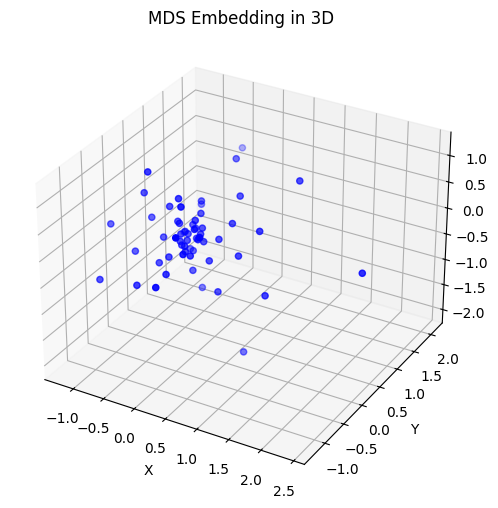

In [12]:
plot_mds_3d(x,y,z)

In [15]:
%%timeit
points = localcoordsampling_2sphere(10)
points = np.array(points)
x, y, z = mds(points, 0.01, 3)

There are 10 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 9 (90.00%)
There are 10 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 9 (90.00%)
There are 10 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 9 (90.00%)
There are 10 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 9 (90.00%)
There are 10 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 9 (90.00%)
There are 10 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 9 (90.00%)
There are 10 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 9 (90.00%)
There are 10 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 9 (90.00%)
420 ms ± 9.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
